In [25]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

from keras.models import load_model
import random

LABELS_FILENAME = "model_label.dat"
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"

In [26]:
# start the data and classes array
data = []
labels = []

# check every input image
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):    
    # load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # change the letter size to make is be 20x20
    image = cv2.resize(image, (20, 20))
    
    
    # add a third dimension to make a 3D tensor which is the way keras spects images to be
    image = np.expand_dims(image, axis=2)
    
        
    # takes the name of the letter from the directory it was in
    label = image_file.split(os.path.sep)[-2]

    # adds the image and the class to the data and labels a lists
    data.append(image)
    labels.append(label)

In [27]:
# turns the image and the label into numpy arrays and normalizes fields in the image
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [28]:
# devides the data into train and test set
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# turns the labels into one-hot encoded vectors
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# saves the fittet transformer
pickle.dump(lb, open(LABELS_FILENAME, 'wb'))

# takes away one dimension in order to display the image
# result = X_train[50][:, :, 0]

# print(result.shape)
# plt.imshow(result, cmap = plt.cm.binary)
# plt.title(Y_train[50])

In [29]:
# Build the Neuralnet!
model = Sequential()
# Defines the convolutional layers
model.add(Conv2D(20, (2,2), input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(2))

model.add(Conv2D(50, (2,2), activation="relu"))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(500, activation="relu"))
# output layer with one neuron for each class
model.add(Dense(36, activation="softmax"))

# compiles the nn
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 19, 19, 20)        100       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 20)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 50)          4050      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 50)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 500)              

In [30]:
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.4, batch_size=64, verbose=1)

Epoch 1/50
608/608 [==============================] - 9s 15ms/step - loss: 0.9507 - accuracy: 0.7726 - val_loss: 0.4673 - val_accuracy: 0.8791
Epoch 2/50
608/608 [==============================] - 9s 14ms/step - loss: 0.3746 - accuracy: 0.9023 - val_loss: 0.3479 - val_accuracy: 0.9050
Epoch 3/50
608/608 [==============================] - 8s 13ms/step - loss: 0.2766 - accuracy: 0.9250 - val_loss: 0.2997 - val_accuracy: 0.9174
Epoch 4/50
608/608 [==============================] - 8s 13ms/step - loss: 0.2214 - accuracy: 0.9379 - val_loss: 0.2531 - val_accuracy: 0.9324
Epoch 5/50
608/608 [==============================] - 8s 13ms/step - loss: 0.1787 - accuracy: 0.9488 - val_loss: 0.2462 - val_accuracy: 0.9336
Epoch 6/50
608/608 [==============================] - 8s 12ms/step - loss: 0.1492 - accuracy: 0.9559 - val_loss: 0.2438 - val_accuracy: 0.9352
Epoch 7/50
608/608 [==============================] - 8s 13ms/step - loss: 0.1234 - accuracy: 0.9639 - val_loss: 0.2448 - val_accuracy: 0.9359

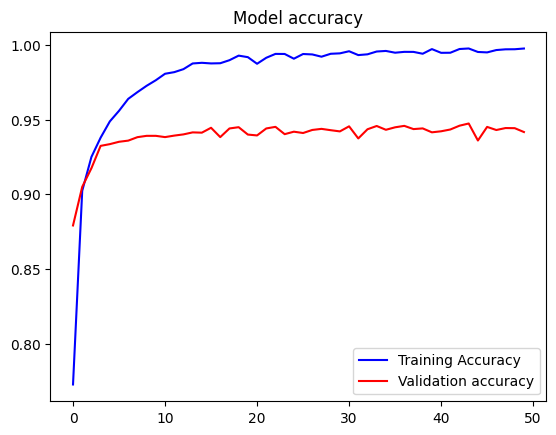

In [31]:
# plots the model's performance
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Model accuracy')
plt.legend()
plt.show()

In [32]:
loss, accuracy = model.evaluate(X_test, Y_test)

675/675 [==============================] - 2s 3ms/step - loss: 0.4636 - accuracy: 0.9411


In [33]:
accuracy

0.9410783648490906

In [34]:
# Saves the model for latter use
model.save(MODEL_FILENAME)